# RBA SOMP Forecasts

## Set-up

In [1]:
# system imports
import io
from pathlib import Path
from typing import TypeAlias, cast

# analytic imports
import matplotlib.pyplot as plt
from matplotlib import colormaps
import numpy as np
import pandas as pd
from plotting import clear_chart_dir, finalise_plot, set_chart_dir

In [2]:
# local imports
import abs_data_capture
import rba_data_capture
import common
import utility

# plotting constants
CHART_DIR = "./CHARTS/SOMP"
Path(CHART_DIR).mkdir(parents=True, exist_ok=True)
clear_chart_dir(CHART_DIR)
set_chart_dir(CHART_DIR)
plt.style.use("fivethirtyeight")
SHOW = True

## Collect SOMP data

### Get raw SOMP tables

In [3]:
START_YEAR = 2019
STOP_YEAR = 2025  # - this will need updating from year to year

In [4]:
def data_cleaning(frame: pd.DataFrame) -> pd.DataFrame:
    """Preliminary data cleaning for the raw SOMP
    data captured from the RBA website."""

    for col in frame.columns:

        # convert text fractions to decimals
        frame[col] = (
            frame[col]
            .astype(str)
            .str.replace("¼", ".25")
            .str.replace("½", ".5")
            .str.replace("¾", ".75")
            .str.replace("−", "-")
        )

        # make to NaN all non-numeric data
        frame[col] = pd.to_numeric(frame[col], errors="coerce")

    # delete all-NaN rows
    frame = frame = frame.dropna(how="all", axis="index")

    # remove odd footnotes introduced in Feb 2024
    # and standardise the case used in the index
    frame.index = frame.index.str.replace(r"\([a-z]\)$", "", regex=True).str.title()

    return frame

In [5]:
DateSompType: TypeAlias = dict[str, pd.DataFrame]


def collect_somp_data() -> DateSompType:
    """Collect raw SOMP data, as presented in these SOMP
    reports. Returns one table for each report in a dict."""

    cache_dir = "./RBA_SOMP_CACHE"
    cache = Path(cache_dir)
    cache.mkdir(parents=True, exist_ok=True)
    q_start = {"feb": 1, "may": 2, "aug": 3, "nov": 4}

    pool: DateSompType = {}
    for year in range(START_YEAR, STOP_YEAR):
        for qtr, q_number in q_start.items():

            # get URL
            url = (
                (
                    "https://www.rba.gov.au/publications"
                    f"/smp/{year}/{qtr}/forecasts.html"
                )
                if year < 2024
                else (
                    # Change of RBA data location in Feb 2024 ...
                    "https://www.rba.gov.au/publications"
                    f"/smp/{year}/{qtr}/outlook.html"
                )
            )

            # get the HTML text found at URL
            try:
                file = common.get_file(url, cache)
            except common.HttpError:
                print(f"Did not get: {year}-{qtr}")
                continue
            
            # get and clean relevant table from the HTML
            frame_list = pd.read_html(io.BytesIO(cast(bytes, file)), index_col=0)
            relevant_table = 0
            frame = data_cleaning(frame_list[relevant_table])

            # save the table into a dict
            index = f"{year}-Q{q_number}"
            pool[index] = frame

    return pool

In [6]:
raw_somp = collect_somp_data()

Retrieving data from cache: RBA_SOMP_CACHE/a1379dd0a92bd4626c9f86a01864ca7a--forecasts.html
Retrieving data from cache: RBA_SOMP_CACHE/73d98da9e9b4cb61f9a2b7ec484666c8--forecasts.html
Retrieving data from cache: RBA_SOMP_CACHE/dbc5bd06d495148c7ec5d9f423911d09--forecasts.html
Retrieving data from cache: RBA_SOMP_CACHE/9a5ae921c14572463601b945bf77e2ac--forecasts.html
Retrieving data from cache: RBA_SOMP_CACHE/67549187a6a3d7fffe7a792631b7b08d--forecasts.html
Retrieving data from cache: RBA_SOMP_CACHE/b37e01367aeff06d7982501f07bb0dbe--forecasts.html
Retrieving data from cache: RBA_SOMP_CACHE/6c8ad34d268f122e9d7f2dc5231e1fdc--forecasts.html
Retrieving data from cache: RBA_SOMP_CACHE/bab514a8e41482bad760e1d86696c366--forecasts.html
Retrieving data from cache: RBA_SOMP_CACHE/e8497feee2f9cc80ff8502b518709a2c--forecasts.html
Retrieving data from cache: RBA_SOMP_CACHE/889b66a1af4e66f440c092d128094cf3--forecasts.html
Retrieving data from cache: RBA_SOMP_CACHE/935401f104a40cf7282a69bdc3c647fd--for

### Reorganise SOMP data

In [7]:
DomainSompType: TypeAlias = dict[str, pd.DataFrame]


def reorganise_somp(inputs: dict[str, pd.DataFrame]) -> DomainSompType:
    """Reorganise the SOMP data
    from tables by date to tables by domain."""

    ue = "Unemployment Rate"
    pool: DomainSompType = {}
    for index, frame in inputs.items():
        for item in frame.index:
            if item[0] == "(":
                continue  # ignore footnotes
            row = frame.loc[item]
            row.name = index
            item_adj = ue if ue in item else item
            if item_adj not in pool:
                pool[item_adj] = pd.DataFrame(row)
            else:
                pool[item_adj] = pd.concat([pool[item_adj], pd.DataFrame(row)], axis=1)

    for table in pool.values():
        table.columns = pd.PeriodIndex(table.columns, freq="Q-NOV")
        table.index = pd.PeriodIndex(table.index, freq="Q-DEC")

    return pool

In [8]:
somp: DomainSompType = reorganise_somp(raw_somp)
somp.keys()

dict_keys(['Gross Domestic Product', 'Household Consumption', 'Dwelling Investment', 'Business Investment', 'Public Demand', 'Gross National Expenditure', 'Imports', 'Exports', 'Real Household Disposable Income', 'Terms Of Trade', 'Major Trading Partner (Export-Weighted) Gdp', 'Unemployment Rate', 'Employment', 'Wage Price Index', 'Nominal (Non-Farm) Average Earnings Per Hour', 'Trimmed Mean Inflation', 'Consumer Price Index', 'Hours-Based Underutilisation Rate (Quarterly, %)', 'Nominal Average Earnings Per Hour (Non-Farm)', 'Cash Rate (%)', 'Trade-Weighted Index (Index)', 'Brent Crude Oil Price (Us$/Bbl)', 'Estimated Resident Population', 'Labour Productivity', 'Household Savings Rate (%)', 'Real Wage Price Index', 'Real Average Earnings Per Hour (Non-Farm)'])

In [9]:
# somp["Nominal (Non-Farm) Average Earnings Per Hour"]

## Get ABS data

In [10]:
# some helpful typing information

SelectorType: TypeAlias = tuple[str, str, str, str, str, bool]
# Note the members of a SelectorType tuple could be named as follows
# catalog_id, table_number, data_type, serach1, search2, calc_growth

MeasureType: TypeAlias = dict[str, SelectorType]
AbsDataType: TypeAlias = dict[str, pd.Series]

In [11]:
def get_abs(measure: MeasureType) -> AbsDataType:
    """Return a dictionary of Series data from the ABS,
    Once series for each item in the measure dictionary."""

    pool = {}
    (
        did_col,
        _,  # id_col
        table_col,
        type_col,
        _,  # unit_col
        _,  # tdesc_col
    ) = abs_data_capture.get_meta_constants()

    for m, (cat, table, season, did1, did2, calc_growth) in measure.items():
        print(m)

        # get the ABS data
        data_dict = abs_data_capture.get_abs_meta_and_data(cat)
        _, _, meta_data = abs_data_capture.get_fs_constants(cat)
        meta = data_dict[meta_data]
        data = data_dict[table]

        # get the specific series we want to plot
        search_terms = {
            table: table_col,
            {"SA": "Seasonally Adjusted", "Orig": "Original"}[season]: type_col,
            did1: did_col,
            did2: did_col,
        }
        series_id, _ = abs_data_capture.find_id(meta, search_terms, verbose=True)
        series = data[series_id]
        index = series.index
        if calc_growth:
            periods = 4 if index.freqstr[0] == "Q" else 12
            series = (series / series.shift(periods) - 1) * 100.0
        pool[m] = series

    return pool

## Plotting

### Utility functions

In [12]:
def plot_somp(ax, somp_df: pd.DataFrame):
    """Add the quarterly SOMP forecasts to a plot."""

    n_colours = len(somp_df.columns)
    gradient = np.linspace(0, 1, n_colours)
    cmap = cmap = plt.get_cmap('viridis')
    colors = cmap(gradient)
    xy = set()
    last = somp_df.columns[-1]

    for col, color in zip(somp_df.columns, colors):
        s = somp_df[col].dropna().astype(float)  # kludge
        if s.index[0].year < START_YEAR:
            continue
        color = "darkred" if col == last else color
        s.plot(ax=ax, lw=1.5, c=color, label=str(col)[2:])
        x, y = s.index[-1], s.iloc[-1]
        # let's minimise over-plotting of text
        va = "bottom" if (x, y) not in xy else "top"
        ax.text(x=x, y=y, s=str(col)[2:], fontsize=6, va=va)
        xy.add((x, y))

In [13]:
def plot_annual_growth(
    growth_data: AbsDataType,
    measures: MeasureType,
    somp_data: DomainSompType,
    ylabel: str = "Growth (per cent per year)",
) -> None:
    """Produce a plot for the selected input."""

    for name, abs_series in growth_data.items():
        (
            cat,
            table,
            season,
            _,  # did1
            _,  # did2
            _,  # calc_growth
        ) = measures[name]

        somp_df = somp_data[name]
        if abs_series.index.freqstr[0] == "M":
            somp_df = utility.qtly_to_monthly(somp_df)

        _, ax = plt.subplots()
        plot_somp(ax, somp_df)
        abs_series[abs_series.index.year >= START_YEAR - 1].plot(
            ax=ax, lw=3.5, color="red", alpha=0.65, label="ABS"
        )

        title = f"{name} (with Qrtly RBA SOMP forecasts)"
        fold_line_threshold = 55
        if len(title) > fold_line_threshold:
            # replace the last occurrence
            old = " ("
            new = "\n("
            title = (title[::-1].replace(old[::-1], new[::-1], 1))[::-1]
        finalise_plot(
            ax,
            title=title,
            ylabel=ylabel,
            lfooter=f"Australia. {season} series.",
            rfooter=f"RBA SOMP. ABS {cat} {table}.",
            legend={"ncols": 1, "loc": "center left", "fontsize": "xx-small"},
            y0=True,
            show=SHOW,
        )

### Annual Growth Measures

In [14]:
growth_measures: MeasureType = {
    "Gross Domestic Product": (
        "5206",
        "1",
        "SA",
        "Chain volume measures ;",
        "Gross domestic product:",
        True,
    ),
    "Household Consumption": (
        "5206",
        "8",
        "SA",
        "Chain volume measures ;",
        "FINAL CONSUMPTION EXPENDITURE:",
        True,
    ),
    "Dwelling Investment": (
        "5206",
        "2",
        "SA",
        "Private ;  Gross fixed capital formation - Dwellings - Total ;",
        "Private ;  Gross fixed capital formation - Dwellings - Total ;",
        True,
    ),
    # "Business Investment": (
    #
    #    # -- Needs work - ‘Business investment’ and ‘Public demand’ have been
    #    # adjusted to exclude the effects of net sales of existing capital
    #    # assets between the private and other (public and external) sectors.
    #
    #    "5206",
    #    "2",
    #    "SA",
    #    "Private ;  Gross fixed capital formation ;",
    #    "Private ;  Gross fixed capital formation ;",
    #    True,
    # ),
    # "Public Demand": (
    #
    #    # Needs work - see above
    #
    #    "5206",
    #    "24",
    #    "SA",
    #    "Public ;  Final demand: Chain volume measures ;",
    #    "Public ;  Final demand: Chain volume measures ;",
    #    True,
    # ),
    "Gross National Expenditure": (
        "5206",
        "2",
        "SA",
        "Gross national expenditure ;",
        "Gross national expenditure ;",
        True,
    ),
    "Imports": (
        "5206",
        "2",
        "SA",
        "Imports of goods and services ;",
        "Imports of goods and services ;",
        True,
    ),
    "Exports": (
        "5206",
        "2",
        "SA",
        "Exports of goods and services ;",
        "Exports of goods and services ;",
        True,
    ),
    # - Series stops with 23Q4 ... Replaced by
    #  'Real Average Earnings Per Hour (Non-Farm)'
    #   in 24Q1 SOMP
    # "Nominal (Non-Farm) Average Earnings Per Hour": (
    #    "5206",
    #    "24",
    #    "SA",
    #    "Current prices ;",
    #    "Non-farm compensation of employees per hour:",
    #    True,
    # ),
    "Wage Price Index": (
        "6345",
        "1",
        "SA",
        "Percentage Change From Corresponding Quarter of Previous Year",
        "Australia ;  Total hourly rates of pay excluding bonuses ;  "
        + "Private and Public ;  All industries ;",
        False,
    ),
    "Trimmed Mean Inflation": (
        "6401",
        "8",
        "SA",
        "Percentage Change from Corresponding Quarter of Previous Year",
        "Trimmed Mean ;  Australia ;",
        False,
    ),
    "Consumer Price Index": (
        "6401",
        "2",
        "Orig",
        "Percentage Change from Corresponding Quarter of Previous Year",
        "All groups CPI ;  Australia ;",
        False,
    ),
}

Gross Domestic Product
Found URL for a ZIP file on ABS web page
Retrieving data from cache: ABS_CACHE/5017be8287dea982b865689c39593eff--All_time_series_workbooks.zip
Extracting DataFrames from the zip-file ...
Household Consumption
Dwelling Investment
Gross National Expenditure
Imports
Exports
Wage Price Index
Found URL for a ZIP file on ABS web page
Retrieving data from cache: ABS_CACHE/6052268df887aaf3a0774941b419dc9b--Time-series-spreadsheets-all.zip
Extracting DataFrames from the zip-file ...
Trimmed Mean Inflation
Found URL for a ZIP file on ABS web page
Retrieving data from cache: ABS_CACHE/009cab4e5b98e8a0836b649cecbac43a--All-Time-Series-Spreadsheets.zip
Extracting DataFrames from the zip-file ...
Consumer Price Index


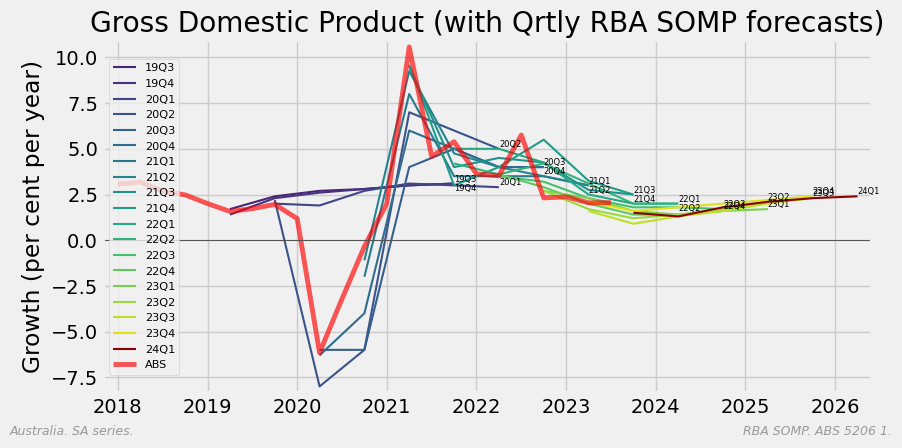

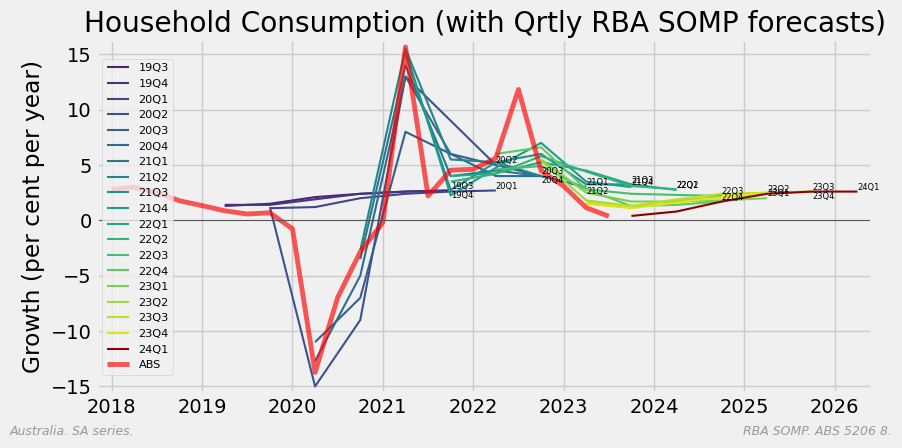

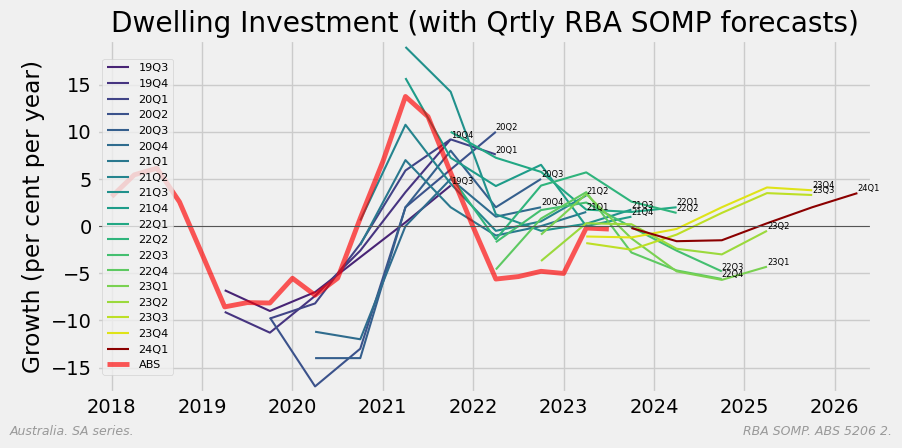

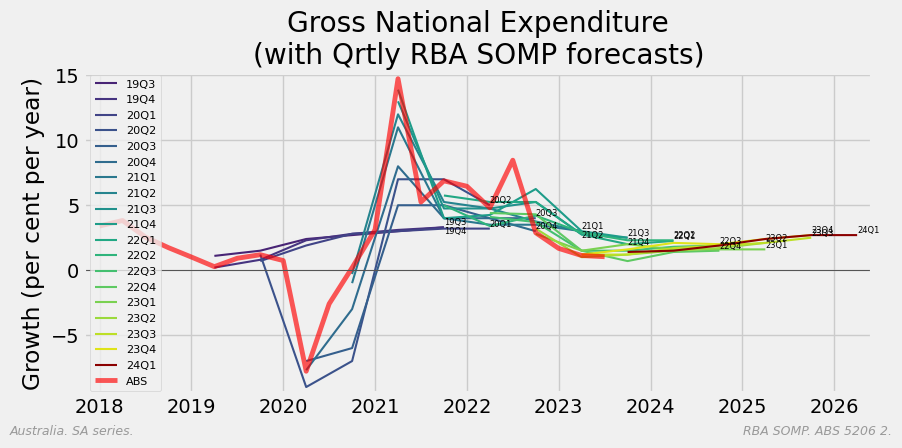

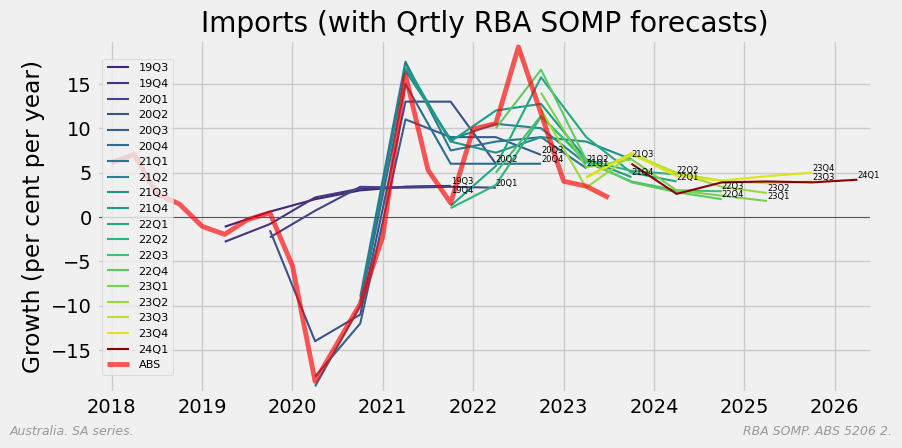

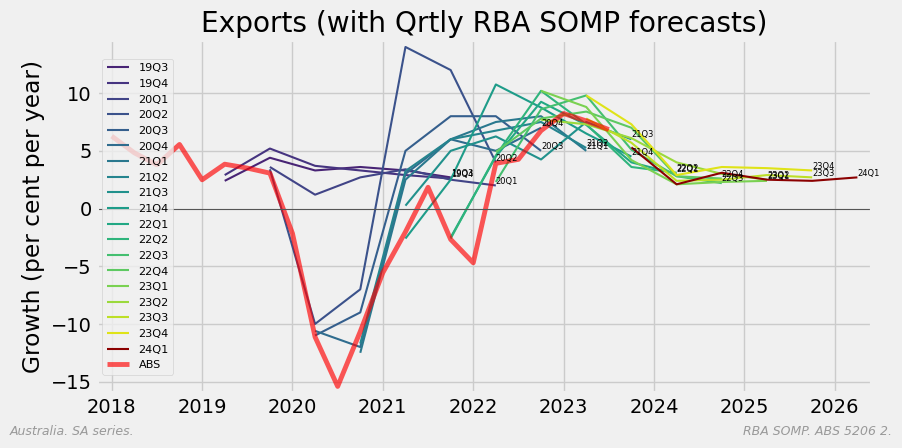

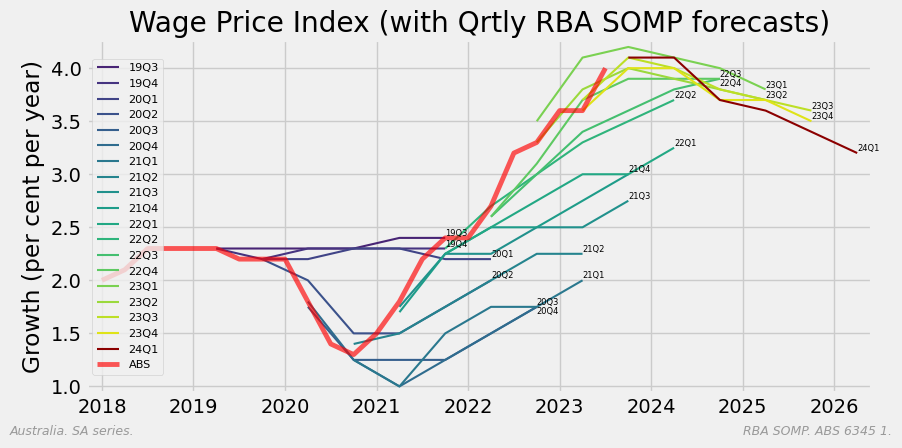

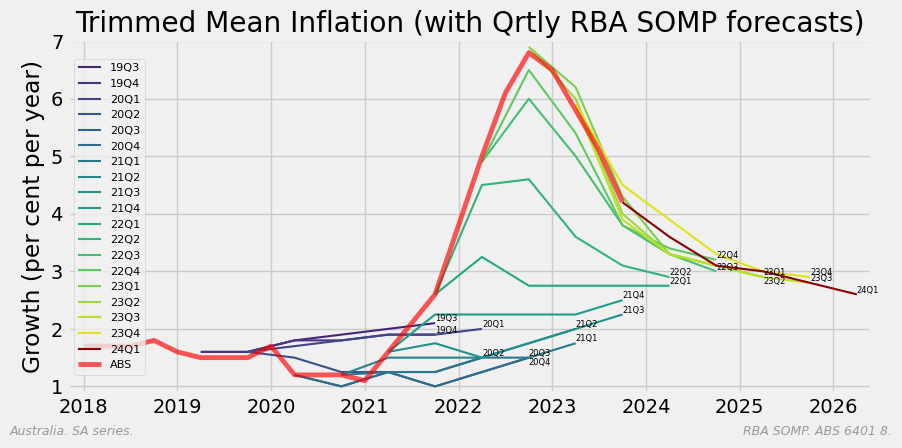

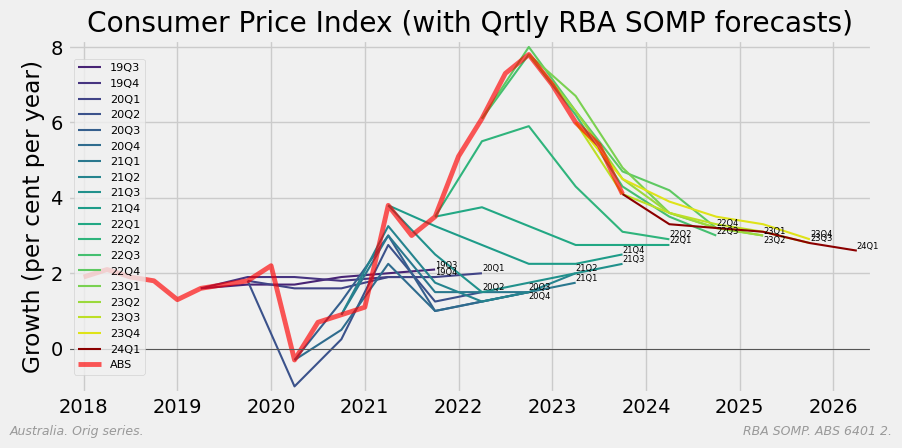

In [15]:
plot_annual_growth(get_abs(growth_measures), growth_measures, somp)

### Real household disposable income
See table H from the RBA Statistical Tables: 'Real household disposable income' is household disposable income after the deduction of interest payments, deflated by the implicit price deflator for household consumption expenditure; includes income from unincorporated enterprises.

In [16]:
di_measures: MeasureType = {
    "Disposable income": (
        "5206",
        "20",
        "SA",
        "GROSS DISPOSABLE INCOME ;",
        "GROSS DISPOSABLE INCOME ;",
        False,
    ),
    "HFCE deflator": (
        "5206",
        "5",
        "SA",
        " ",
        "Households ;  Final consumption expenditure ;",
        False,
    ),
}


def plot_di(somp_data: DomainSompType):
    """Plot disposable income"""

    di_data = get_abs(di_measures)
    deflator = di_data["HFCE deflator"] / 100.0
    rhdi = di_data["Disposable income"] / deflator
    growth = (rhdi / rhdi.shift(4) - 1) * 100.0
    growth_data = {"Real Household Disposable Income": growth}
    fake_measure = {
        "Real Household Disposable Income": [
            "5206",
            ", ".join([x[1] for x in di_measures.values()]),
            "SA",
            "-",
            "-",
            True,
        ],
    }
    plot_annual_growth(growth_data, fake_measure, somp_data)

Disposable income
HFCE deflator


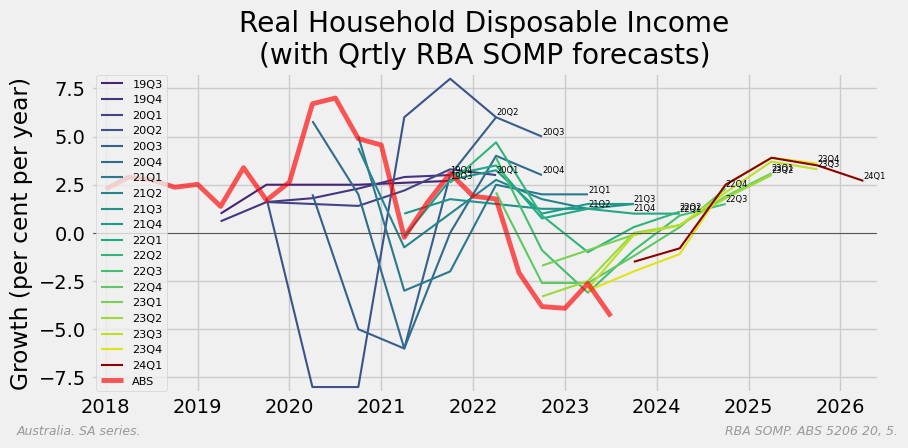

In [17]:
plot_di(somp)

### Unemployment rate

Note: The UE rate n SMOP is a quarterly figure, which we are plotting against a monthly ABS series. This is not quite apples and oranges.

In [18]:
# Force UE data to be quarterly
UE_QUARTERLY = False


def plot_ue():
    """Plot the SOMP UE forecasts."""

    ue_text = "Unemployment Rate"
    ue_measure = {
        ue_text: (
            "6202",
            "1",
            "SA",
            "Unemployment rate ;",
            "Persons",
            False,
        ),
    }

    ue_data = get_abs(ue_measure)

    if UE_QUARTERLY:
        #  Convert monthly UE data to Quarterly.
        ue_data[ue_text] = utility.monthly_to_qtly(ue_data[ue_text])

    plot_annual_growth(ue_data, ue_measure, somp, ylabel="Unemployment Rate (%)")

Unemployment Rate
Found URL for a ZIP file on ABS web page
Retrieving data from cache: ABS_CACHE/b44a486f4e4965196a7fd74c7621c283--p6202_all_monthly_spreadsheets.zip
Extracting DataFrames from the zip-file ...


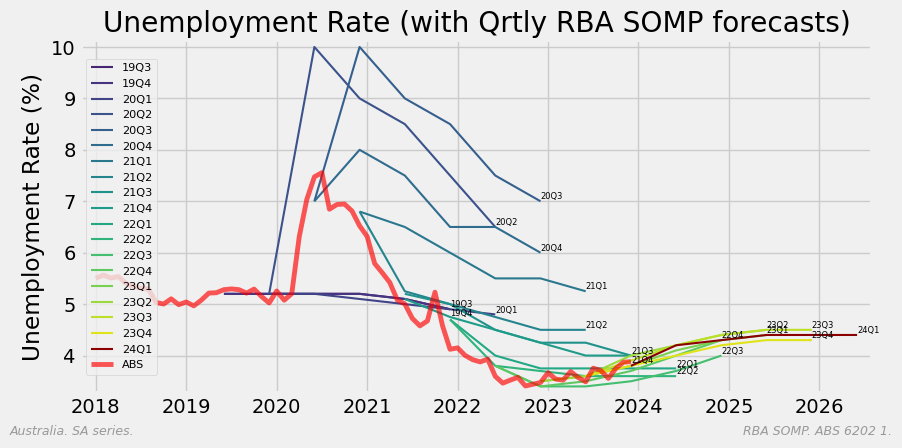

In [19]:
plot_ue()

### Number in Employment

In [20]:
# Force E data to be quarterly
E_QUARTERLY = False


def plot_employment():
    """Plot the SOMP Employment forecasts."""

    e_text = "Employment"
    e_measure = {
        e_text: (
            "6202",
            "1",
            "SA",
            "Employed total ;",
            "Persons",
            True,
        ),
    }

    e_data = get_abs(e_measure)
    if E_QUARTERLY:
        #  Convert monthly Employment data to Quarterly.
        e_data[e_text] = utility.monthly_to_qtly(e_data[e_text])

    plot_annual_growth(e_data, e_measure, somp)

Employment


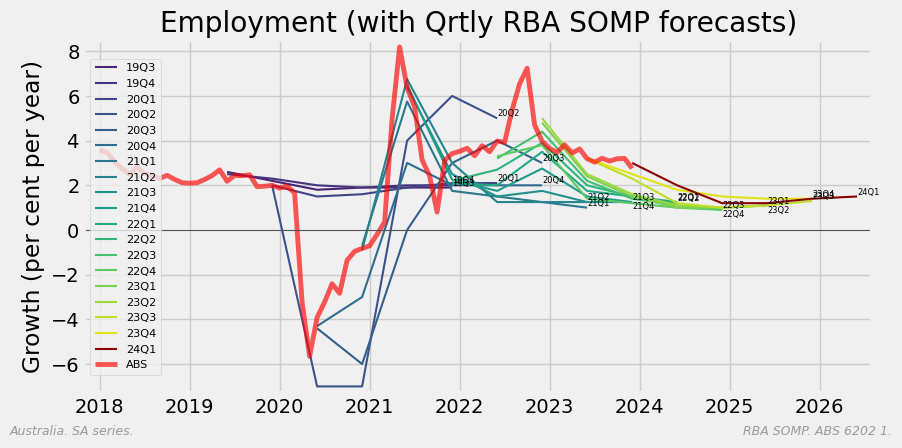

In [21]:
plot_employment()

### Cash rate

In [22]:
def plot_cr():
    """Produce a cash rate chart."""

    cr = "Cash Rate (%)"

    # plot the official cash rate history
    a2 = rba_data_capture.get_data("Monetary Policy Changes – A2")
    a2_meta, a2_data = a2 if a2 is not None else (None, None)
    target = "New Cash Rate Target"
    series_id = a2_meta[a2_meta.Title == target].index[0]
    ocr_rba = a2_data[series_id].to_period(freq="M")
    ocr_rba = ocr_rba[~ocr_rba.index.duplicated(keep="last")]
    new_index = pd.period_range(
        start=ocr_rba.index.min(), end=(pd.Timestamp.now().to_period(freq="M"))
    )
    ocr_rba = ocr_rba.reindex(new_index, fill_value=np.nan).ffill()
    ocr_rba = ocr_rba[ocr_rba.index.year >= START_YEAR]
    ax = ocr_rba.plot(
        drawstyle="steps-post", c="red", alpha=0.65, label="RBA Cash Rate"
    )

    # plot RBA SOMP forecasts
    somp_cr = utility.qtly_to_monthly(somp[cr])
    plot_somp(ax, somp_cr)

    # and foinalise
    finalise_plot(
        ax,
        title=f"{cr} (with Qrtly RBA SOMP forecasts)",
        ylabel=cr,
        lfooter="Australia.",
        rfooter="RBA SOMP.",
        legend={"ncols": 1, "loc": "center left", "fontsize": "xx-small"},
        y0=True,
        show=SHOW,
    )

Retrieving data from cache: RBA_CACHE/a296718e2fda7d15d3e636d9aca9c548--a02hist.xls


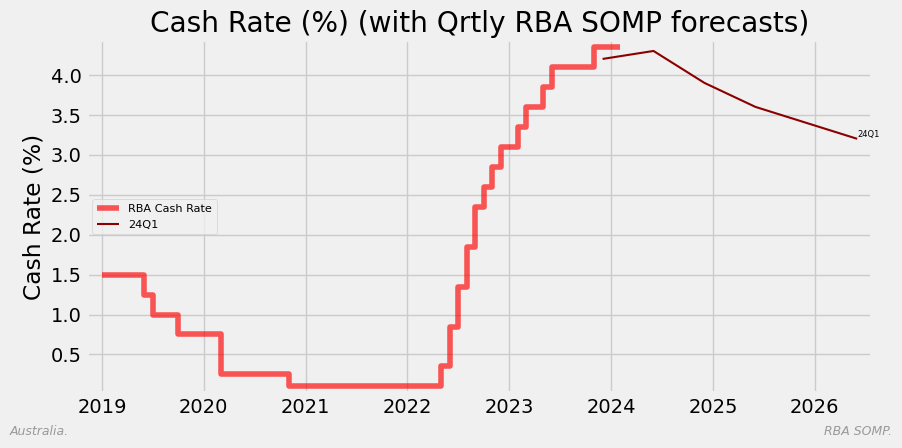

In [23]:
plot_cr()

## Finished

In [24]:
%load_ext watermark
%watermark -u -n -t -v -iv -w

Last updated: Thu Feb 08 2024 21:16:55

Python implementation: CPython
Python version       : 3.11.7
IPython version      : 8.21.0

pandas    : 2.2.0
numpy     : 1.26.4
matplotlib: 3.8.2

Watermark: 2.4.3



In [25]:
print("Finished.")

Finished.
